In [1]:
import os
#import gdown
from skimage.transform import resize
import numpy as np
import tensorflow as tf
from keras import backend as K
import matplotlib.pyplot as plt
import cv2


In [2]:
physical_device=tf.config.list_physical_devices('GPU')
print(physical_device)

try:
    tf.config.experimental.set_memory_growth(physical_device[0],True)
except:
    pass

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
# Checking if dataset directory is present , if not then create 'dataset' folder and download it
path=os.getcwd()
dataset_dir=os.path.join(path,'dataset')

if dataset_dir.split(os.sep)[-1] not in os.listdir(path):  
    os.mkdir(dataset_dir)

    url = 'https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL'
    output = 'data.zip'

    gdown.download(url,os.path.join(dataset_dir,output))

    gdown.extractall(os.path.join(dataset_dir,output))

In [4]:
#Download model "shape_predictor_68_face_landmarks.dat" provided by dlib to extract mouth/lips part from image 
#Download model if already not present

import bz2
from urllib.request import urlretrieve

face_landmark_predictor_path=os.path.join(path,"shape_predictor_68_face_landmarks.dat")

all_files=os.listdir(path)
if "shape_predictor_68_face_landmarks.dat" not in all_files:
    
    if "shape_predictor_68_face_landmarks.dat.bz2" not in all_files:
        
        #Download file
        #Command line prompt:
        #!wget "http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2"
        #OR
        #Python codes:
        urlretrieve("http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2","shape_predictor_68_face_landmarks.dat.bz2")
    
    
    # Extracting compressed .bz2 format 
    
    #Command line prompt to extract
    #!bzip2 -d shape_predictor_68_face_landmarks.dat.bz2
    
    ##OR
    
    #Python code to extract
    filename="shape_predictor_68_face_landmarks.dat.bz2"
    filepath = os.path.join(path, filename)
    newfilepath = os.path.join(path, 'shape_predictor_68_face_landmarks.dat')
    with open(newfilepath, 'wb') as new_file, bz2.BZ2File(filepath, 'rb') as file:
        for data in iter(lambda : file.read(100 * 1024), b''):
            new_file.write(data)

In [5]:
import glob

video_files_dir_path=os.path.join(dataset_dir,'data','s1')
video_file_list=glob.glob(os.path.join(video_files_dir_path,'*.mpg'))
total_videos=len(video_file_list)

alignments_files_path=os.path.join(dataset_dir,'data','alignments','s1')
alignments_files_list=glob.glob(os.path.join(alignments_files_path,'*.align'))

numpy_files_dir_path=os.path.join(dataset_dir,'data','extracted_mouth_3_channels_rgb')
numpy_files_list=glob.glob( os.path.join(numpy_files_dir_path,'*.npy') )

In [ ]:
# #TO extract lips from face in all videos for training:

# path_to_extract_lips=os.path.join(dataset_dir,'data','extracted_mouth_3_channels_rgb')
# os.mkdir(path_to_extract_lips)
# video=Video(vtype = 'face',face_predictor_path=face_landmark_predictor_path)
# for video_path in video_file_list:
#     video_name=video_path.split(os.sep)[-1].split('.')[0]
#     vid=video.from_video(video_path)
#     with open(f"{path_to_extract_lips}/{video}.npy",'wb') as f:
#         np.save(f,vid.mouth)

In [6]:
numpy_files_list[0]

'd:\\projects\\lipnet\\dataset\\data\\extracted_mouth_3_channels_rgb\\bbaf2n.npy'

In [4]:
# wrong_files=[]
# for path in numpy_files_list:
#     with open(path,'rb') as f:
#         vid=np.load(f)
#     if vid.shape != (75,50,100,3):
#         wrong_files.append(path)

wrong_files=['d:\\projects\\lipnet\\dataset\\data\\extracted_mouth_3_channels_rgb\\bbizzn.npy',
 'd:\\projects\\lipnet\\dataset\\data\\extracted_mouth_3_channels_rgb\\brwa4p.npy',
 'd:\\projects\\lipnet\\dataset\\data\\extracted_mouth_3_channels_rgb\\brwg8p.npy',
 'd:\\projects\\lipnet\\dataset\\data\\extracted_mouth_3_channels_rgb\\bwwuzn.npy',
 'd:\\projects\\lipnet\\dataset\\data\\extracted_mouth_3_channels_rgb\\lgbf8n.npy',
 'd:\\projects\\lipnet\\dataset\\data\\extracted_mouth_3_channels_rgb\\lrae3s.npy',
 'd:\\projects\\lipnet\\dataset\\data\\extracted_mouth_3_channels_rgb\\lrarzn.npy',
 'd:\\projects\\lipnet\\dataset\\data\\extracted_mouth_3_channels_rgb\\pbio7a.npy',
 'd:\\projects\\lipnet\\dataset\\data\\extracted_mouth_3_channels_rgb\\pbwx1s.npy',
 'd:\\projects\\lipnet\\dataset\\data\\extracted_mouth_3_channels_rgb\\prii9a.npy',
 'd:\\projects\\lipnet\\dataset\\data\\extracted_mouth_3_channels_rgb\\sbbbzp.npy',
 'd:\\projects\\lipnet\\dataset\\data\\extracted_mouth_3_channels_rgb\\sbbh4p.npy',
 'd:\\projects\\lipnet\\dataset\\data\\extracted_mouth_3_channels_rgb\\sran9s.npy',
 'd:\\projects\\lipnet\\dataset\\data\\extracted_mouth_3_channels_rgb\\srbb4n.npy',
 'd:\\projects\\lipnet\\dataset\\data\\extracted_mouth_3_channels_rgb\\srwi5a.npy',
 'd:\\projects\\lipnet\\dataset\\data\\extracted_mouth_3_channels_rgb\\swao7a.npy']

for wrong_file in wrong_files:
    numpy_files_list.remove(wrong_file)

In [24]:
from lipnet_model import LipNet

def set_data( frames):
    data_frames = []
    for frame in frames:
        frame = frame.swapaxes(0,1) # swap width and height to form format W x H x C
        if len(frame.shape) < 3:
            frame = np.array([frame]).swapaxes(0,2).swapaxes(0,1) # Add grayscale channel
        data_frames.append(frame)
    frames_n = len(data_frames)
    data_frames = np.array(data_frames) # T x W x H x C
    if K.image_data_format() == 'channels_first':
        data_frames = np.rollaxis(data_frames, 3) # C x T x W x H
    return data_frames


with open(numpy_files_list[6],'rb') as f:
    frames=np.load(f)
    #print(frames)
frames=set_data(frames)
frames=frames[np.newaxis,...]/255
#print(frames)

lipnet=LipNet()
lipnet.model.load_weights("D:\projects\lipnet\saved_weights\checkpoint_350.h5")
ypred=lipnet.model.predict(frames)
decoder=Decoder(postprocessors=[labels_to_text])
print(decoder.decode(ypred,[75]))



1/1 [==============================] - 1s 1s/step
['bin blue at l eight please']


In [6]:
def get_video_frames(path):
    #videogen = skvideo.io.vreader(path)
    #frames = np.array([frame for frame in videogen])
    #return frames
    #----------------
    cap = cv2.VideoCapture(path)
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))): 
        ret, frame = cap.read()
        #frame=cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        frame=cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(frame)
    cap.release()
    return frames


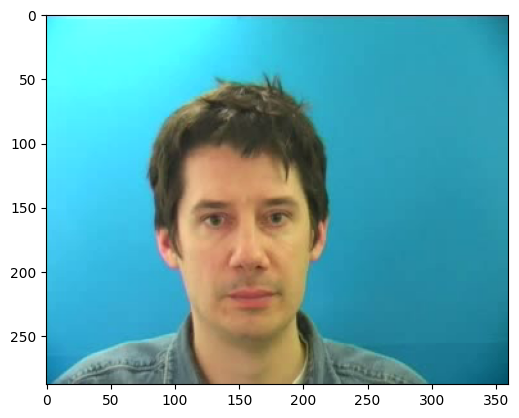

In [11]:
frames=get_video_frames(video_file_list[0])
frames[0].shape
plt.imshow(frames[0])

In [8]:
with open(numpy_files_list[6],'rb') as f:
    frames=np.load(f)

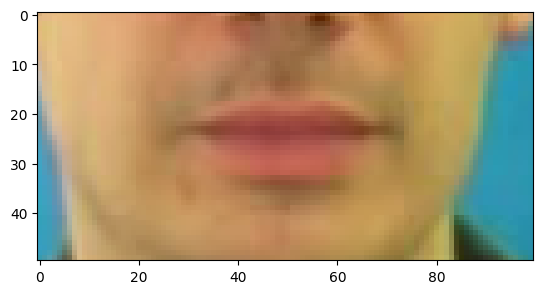

In [10]:
plt.imshow(frames[0])

In [60]:
# #Save gif
# import imageio

# with open(numpy_files_list[6],'rb') as f:
#     frames=np.load(f)

# #print(frames.astype(np.uint8))
# frames_normalized = (frames - np.min(frames)) / (np.max(frames) - np.min(frames))

# # Convert normalized float32 frames to uint8
# frames_uint8 = (frames_normalized * 255).astype(np.uint8)

# imageio.mimsave("animation.gif",frames_uint8 ,duration=1/40)

In [15]:
class Align(object):
    def __init__(self, absolute_max_string_len=32, label_func=None):
        self.label_func = label_func
        self.absolute_max_string_len = absolute_max_string_len

    def from_file(self, path):
        with open(path, 'r') as f:
            lines = f.readlines()
        align = [(y[0], y[1], y[2]) for y in [x.strip().split(" ") for x in lines]]
        self.build(align)
        return self

    def from_array(self, align):
        self.build(align)
        return self

    def build(self, align):
        self.align = self.strip(align, ['sp','sil'])
        self.sentence = self.get_sentence(align)
        self.label = self.get_label(self.sentence)
        #self.padded_label = self.get_padded_label(self.label)

    def strip(self, align, items):
        return [sub for sub in align if sub[2] not in items]

    def get_sentence(self, align):
        return " ".join([y[-1] for y in align if y[-1] not in ['sp', 'sil']])

    def get_label(self, sentence):
        return self.label_func(sentence)

    def get_padded_label(self, label):
        padding = np.ones((self.absolute_max_string_len-len(label))) * -1
        return np.concatenate((np.array(label), padding), axis=0)

    @property
    def word_length(self):
        return len(self.sentence.split(" "))

    @property
    def sentence_length(self):
        return len(self.sentence)

    @property
    def label_length(self):
        return len(self.label)


In [9]:
#import dlib
class Video(object):
    def __init__(self, vtype='mouth', face_predictor_path=None):
        if vtype == 'face' and face_predictor_path is None:
            raise AttributeError('Face video need to be accompanied with face predictor')
        self.face_predictor_path = face_predictor_path
        self.vtype = vtype

    def from_numpy_frames(self, path):
        with open(path,'rb') as f:
            mouth_frames = np.load(f)
        self.mouth=mouth_frames
        self.set_data(mouth_frames)
        return self

    def from_video(self, path):
        frames = self.get_video_frames(path)
        self.handle_type(frames)
        return self

    def handle_type(self, frames):
        if self.vtype == 'mouth':
            self.process_frames_mouth(frames)
        elif self.vtype == 'face':
            self.process_frames_face(frames)
        else:
            raise Exception('Video type not found')

    def process_frames_face(self, frames):
        detector = dlib.get_frontal_face_detector()
        predictor = dlib.shape_predictor(self.face_predictor_path)
        mouth_frames = self.get_frames_mouth(detector, predictor, frames)
        self.face = np.array(frames)
        self.mouth = np.array(mouth_frames)
        self.set_data(mouth_frames)

    def process_frames_mouth(self, frames):
        self.face = np.array(frames)
        self.mouth = np.array(frames)
        self.set_data(frames)

    def get_frames_mouth(self, detector, predictor, frames):
        MOUTH_WIDTH = 100
        MOUTH_HEIGHT = 50
        HORIZONTAL_PAD = 0.19
        normalize_ratio = None
        mouth_frames = []
        for frame in frames:
            dets = detector(frame, 1)
            shape = None
            for k, d in enumerate(dets):
                shape = predictor(frame, d)
                i = -1
            if shape is None: # Detector doesn't detect face, just return as is
                return frames
            mouth_points = []
            for part in shape.parts():
                i += 1
                if i < 48: # Only take mouth region
                    continue
                mouth_points.append((part.x,part.y))
            np_mouth_points = np.array(mouth_points)

            mouth_centroid = np.mean(np_mouth_points[:, -2:], axis=0)

            if normalize_ratio is None:
                mouth_left = np.min(np_mouth_points[:, :-1]) * (1.0 - HORIZONTAL_PAD)
                mouth_right = np.max(np_mouth_points[:, :-1]) * (1.0 + HORIZONTAL_PAD)

                normalize_ratio = MOUTH_WIDTH / float(mouth_right - mouth_left)

            new_img_shape = (int(frame.shape[0] * normalize_ratio), int(frame.shape[1] * normalize_ratio))
            resized_img = resize(frame, new_img_shape)

            mouth_centroid_norm = mouth_centroid * normalize_ratio

            mouth_l = int(mouth_centroid_norm[0] - MOUTH_WIDTH / 2)
            mouth_r = int(mouth_centroid_norm[0] + MOUTH_WIDTH / 2)
            mouth_t = int(mouth_centroid_norm[1] - MOUTH_HEIGHT / 2)
            mouth_b = int(mouth_centroid_norm[1] + MOUTH_HEIGHT / 2)

            mouth_crop_image = resized_img[mouth_t:mouth_b, mouth_l:mouth_r]

            mouth_frames.append(mouth_crop_image)
        return mouth_frames

    def get_video_frames(self, path):
        #videogen = skvideo.io.vreader(path)
        #frames = np.array([frame for frame in videogen])
        #return frames
        #----------------
        cap = cv2.VideoCapture(path)
        frames = []
        for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))): 
            ret, frame = cap.read()
            #frame=cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            frame=cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frames.append(frame)
        cap.release()
        return frames


    def set_data(self, frames):
        data_frames = []
        for frame in frames:
            frame = frame.swapaxes(0,1) # swap width and height to form format W x H x C
            if len(frame.shape) < 3:
                frame = np.array([frame]).swapaxes(0,2).swapaxes(0,1) # Add grayscale channel
            data_frames.append(frame)
        frames_n = len(data_frames)
        data_frames = np.array(data_frames) # T x W x H x C
        if K.image_data_format() == 'channels_first':
            data_frames = np.rollaxis(data_frames, 3) # C x T x W x H
        self.data = data_frames
        self.length = frames_n




In [11]:
def text_to_labels(text):
    ret = []
    for char in text:
        if char >= 'a' and char <= 'z':
            ret.append(ord(char) - ord('a'))
        elif char == ' ':
            ret.append(26)
    return ret

def labels_to_text(labels):
    # 0 is space, 27 is CTC blank char
    text = ''
    for c in labels:
        if c >= 0 and c < 26:
            text += chr(c + ord('a'))
        elif c == 26:
            text += ' '
    return text

In [11]:
labels_to_text ( text_to_labels("my name is khan") ), labels_to_text([0,0,0,0,1,2,26,1,0,5,4,27])

('my name is khan', 'aaaabc bafe')

In [10]:
class Decoder(object):
    def __init__(self, greedy=True, beam_width=100, top_paths=1, postprocessors=None):
        self.greedy         = greedy
        self.beam_width     = beam_width
        self.top_paths      = top_paths
        self.postprocessors = postprocessors
    
    def decode(self, y_pred, input_length):
        if y_pred.ndim==2:
            y_pred=tf.expand_dims(y_pred,0)
            input_length=[75]
        decoded= tf.keras.backend.ctc_decode(y_pred, input_length, greedy=self.greedy, beam_width=self.beam_width,
                         top_paths=self.top_paths)[0][0].numpy()
        
        #print('decoded:',len(decoded),decoded)
        preprocessed = []
        for output in decoded:
            out = output
            #print(out)
            for postprocessor in self.postprocessors:
                out = postprocessor(out)
            preprocessed.append(out)

        return preprocessed

In [13]:
# ypred=lipnet.model.predict(fr)
# decoder=Decoder(postprocessors=[labels_to_text])

# decoder.decode(ypred,[75,75])

In [14]:
from keras.layers import Conv3D, ZeroPadding3D,MaxPooling3D, Dense, Activation, SpatialDropout3D, Flatten, Bidirectional, TimeDistributed,LSTM,GRU,BatchNormalization,Input
from keras.models import Model
from keras import backend as K

class LipNet(object):
    def __init__(self, img_c=3, img_w=100, img_h=50, frames_n=75, output_size=28):
        self.img_c = img_c
        self.img_w = img_w
        self.img_h = img_h
        self.frames_n = frames_n
        self.output_size = output_size
        self.build()

    def build(self):
        if K.image_data_format() == 'channels_first':
            input_shape = (self.img_c, self.frames_n, self.img_w, self.img_h)
        else:
            input_shape = (self.frames_n, self.img_w, self.img_h, self.img_c)
        

        self.input_data = Input(name='the_input', shape=input_shape, dtype='float32')

        self.zero1 = ZeroPadding3D(padding=(1, 2, 2), name='zero1')(self.input_data)
        self.conv1 = Conv3D(32, (3, 5, 5), strides=(1, 2, 2), kernel_initializer='he_normal', name='conv1')(self.zero1)
        self.batc1 = BatchNormalization(name='batc1')(self.conv1)
        self.actv1 = Activation('relu', name='actv1')(self.batc1)
        self.drop1 = SpatialDropout3D(0.5)(self.actv1)
        self.maxp1 = MaxPooling3D(pool_size=(1, 2, 2), strides=(1, 2, 2), name='max1')(self.drop1)

        self.zero2 = ZeroPadding3D(padding=(1, 2, 2), name='zero2')(self.maxp1)
        self.conv2 = Conv3D(64, (3, 5, 5), strides=(1, 1, 1), kernel_initializer='he_normal', name='conv2')(self.zero2)
        self.batc2 = BatchNormalization(name='batc2')(self.conv2)
        self.actv2 = Activation('relu', name='actv2')(self.batc2)
        self.drop2 = SpatialDropout3D(0.5)(self.actv2)
        self.maxp2 = MaxPooling3D(pool_size=(1, 2, 2), strides=(1, 2, 2), name='max2')(self.drop2)

        self.zero3 = ZeroPadding3D(padding=(1, 1, 1), name='zero3')(self.maxp2)
        self.conv3 = Conv3D(96, (3, 3, 3), strides=(1, 1, 1), kernel_initializer='he_normal', name='conv3')(self.zero3)
        self.batc3 = BatchNormalization(name='batc3')(self.conv3)
        self.actv3 = Activation('relu', name='actv3')(self.batc3)
        self.drop3 = SpatialDropout3D(0.5)(self.actv3)
        self.maxp3 = MaxPooling3D(pool_size=(1, 2, 2), strides=(1, 2, 2), name='max3')(self.drop3)

        self.resh1 = TimeDistributed(Flatten())(self.maxp3)

        #self.gru_1 = Bidirectional(GRU(256, return_sequences=True, kernel_initializer='Orthogonal', name='gru1',reset_after=False), merge_mode='concat')(self.resh1)
        #self.gru_2 = Bidirectional(GRU(256, return_sequences=True, kernel_initializer='Orthogonal', name='gru2',reset_after=False), merge_mode='concat')(self.gru_1)

        self.lstm1 = Bidirectional(LSTM(256, kernel_initializer='Orthogonal', return_sequences=True) )(self.resh1)
        self.lstm2 = Bidirectional(LSTM(256, kernel_initializer='Orthogonal', return_sequences=True) )(self.lstm1)

        # transforms RNN output to character activations:
        #self.dense1 = Dense(self.output_size, kernel_initializer='he_normal', name='dense1')(self.gru_2)
        self.dense1 = Dense(self.output_size, kernel_initializer='he_normal', name='dense1')(self.lstm2)

        self.y_pred = Activation('softmax', name='softmax')(self.dense1)

        self.model = Model(inputs=self.input_data, outputs=self.y_pred)

In [15]:
video=Video(face_predictor_path=face_landmark_predictor_path)
align=Align(label_func=text_to_labels)

def get_data(video_path):
    video_path=video_path.numpy().decode()
    video_name=video_path.split(os.sep)[-1].split('.')[0]
    align_path=os.path.join(alignments_files_path,f"{video_name}.align")
    
    frames=video.from_numpy_frames(video_path).data
    align_text=align.from_file(align_path).label

    #Normalize
    frames=tf.cast(frames/255, tf.float32)
    align_text=tf.cast(align_text,tf.int64)

    return frames,align_text


In [16]:
#fr,al=get_data(numpy_files_list[5])

In [17]:
#Loading Data
data=tf.data.Dataset.list_files(numpy_files_list )
total_videos=1000
data=data.shuffle(total_videos, reshuffle_each_iteration=False)

#Test train split
val_size = int(total_videos * 0.2)
train_ds = data.skip(val_size)
val_ds = data.take(val_size)
# train_ds = data.skip(6).take(6)
# val_ds = data.take(6)

# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
AUTOTUNE = tf.data.AUTOTUNE
train_ds=train_ds.map(lambda video_path:tf.py_function(get_data,[video_path],[tf.float32,tf.int64]), num_parallel_calls=AUTOTUNE)
val_ds  =  val_ds.map(lambda video_path:tf.py_function(get_data,[video_path],[tf.float32,tf.int64]), num_parallel_calls=AUTOTUNE)


In [18]:
def configure_for_performance(ds):
  batch_size=2
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.padded_batch(batch_size,padded_shapes=([75,None,None,None],[32,]),padding_values=(0.0,tf.cast(27,tf.int64)))
  #ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

In [19]:
# for fr,al in train_ds:
#     print(fr.shape)

In [20]:
for fr,al in train_ds.take(1):
    #print(al)
    if al.shape[0]>2:
        print(al.shape)
    break

In [21]:
labels_to_text( al[1] )

'lay green by s eight please'

In [22]:
text_to_labels('r'),labels_to_text([0,1,2])

([17], 'abc')

In [23]:
decoder=Decoder(postprocessors=[labels_to_text])

In [24]:
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [25]:
#ypred=lipnet.model.predict(fr)

In [26]:
def scheduler(epoch, lr):
    if epoch < 100:
        return lr
    else:
        return lr * tf.math.exp(-0.1)
    
class ProduceExample(tf.keras.callbacks.Callback): 
    def __init__(self, dataset) -> None: 
        #self.dataset = dataset.as_numpy_iterator()
        self.dataset_iterator = iter(dataset)
    
    def on_epoch_end(self, epoch, logs=None) -> None:
        print("Inside callback")
        data = next(self.dataset_iterator, None)
        if data is None:
            print("Dataset exhausted for this epoch.")
            return
        #data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded_char=decoder.decode(yhat,[75]*len(yhat))
        
        for i in range(len(yhat)): 
            print('Original:', labels_to_text(data[1][i]))
            print('Prediction:', decoded_char[i])
            print('~'*100)

In [27]:
import re
checkpoint_dir = os.path.join(path, 'saved_weights')
try:
    latest_checkpoint = max(glob.glob(os.path.join(checkpoint_dir, 'checkpoint_*.h5')), key=os.path.getctime)
    latest_epoch = int( re.findall(r'_(\d+).h5', latest_checkpoint)[0] )
except:
    latest_epoch=0


In [28]:
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler


checkpoint_callback = ModelCheckpoint(os.path.join(checkpoint_dir,"checkpoint_{epoch:02d}.h5"), monitor='loss', save_weights_only=True,save_freq="epoch") 
schedule_callback = LearningRateScheduler(scheduler)
example_callback = ProduceExample(val_ds)

In [29]:
from keras.optimizers import Adam

lipnet = LipNet()

adam = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
lipnet.model.compile(loss=CTCLoss, optimizer=adam)

#lipnet.model.load_weights("D:\projects\lipnet\overlapped-weights368.h5")
if latest_epoch!=0:
    lipnet.model.load_weights(latest_checkpoint)

num_epochs=350

print(latest_epoch)

350


In [30]:
lipnet.model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 the_input (InputLayer)      [(None, 75, 100, 50, 3)]  0         
                                                                 
 zero1 (ZeroPadding3D)       (None, 77, 104, 54, 3)    0         
                                                                 
 conv1 (Conv3D)              (None, 75, 50, 25, 32)    7232      
                                                                 
 batc1 (BatchNormalization)  (None, 75, 50, 25, 32)    128       
                                                                 
 actv1 (Activation)          (None, 75, 50, 25, 32)    0         
                                                                 
 spatial_dropout3d (SpatialD  (None, 75, 50, 25, 32)   0         
 ropout3D)                                                       
                                                             

In [31]:
lipnet.model.fit(train_ds, validation_data=val_ds, epochs=num_epochs, initial_epoch=latest_epoch,
                  callbacks=[checkpoint_callback,schedule_callback,example_callback])

Epoch 348/350
1/1 [==============================] - 1s 1s/step
Original: lay green at s five again
Prediction: lay green at v five again
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: lay white by l eight please
Prediction: lay white by l eight please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
392/392 [==============================] - 64s 119ms/step - loss: 2.6457 - val_loss: 2.3705 - lr: 9.0484e-05
Epoch 349/350
1/1 [==============================] - 0s 49ms/step
Original: place blue by j zero please
Prediction: place blue by j zero please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Original: bin green in g eight please
Prediction: bin green in g eight please
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
392/392 [==============================] - 36s 92

In [32]:
ypred=lipnet.model.predict(fr)

1/1 [==============================] - 0s 51ms/step


In [33]:
for i,(fr,al) in enumerate(train_ds):
    ypred=lipnet.model(fr)
    text=decoder.decode(ypred,[75]*len(ypred))
    print(i,"Orig:",labels_to_text(al[0]),'||',labels_to_text(al[1]))
    print(i,"Pred:",text[0],'||',text[1])
    print('-'*50)
    

0 Orig: set green in o nine again || place green at e one again
0 Pred: set green in o nine again || place green at e one again
--------------------------------------------------
1 Orig: lay red by l zero now || place blue in o four now
1 Pred: lay red by z zero now || place blue in o four now
--------------------------------------------------
2 Orig: bin green at n seven again || set red in h zero now
2 Pred: bin green at n seven again || set red in h zero now
--------------------------------------------------
3 Orig: lay red with s zero please || bin green at n six please
3 Pred: lay red with z zero please || bin green at n six please
--------------------------------------------------
4 Orig: lay red in k three soon || lay white by z four now
4 Pred: lay red in k three soon || lay white by z four now
--------------------------------------------------
5 Orig: set white with i eight now || bin blue by z eight now
5 Pred: set white with i eight now || bin blue by z eight now
-----------

In [35]:
decoder.decode(ypred,[75]*len(ypred))

['set green by j one soon', 'set red by h nine soon']

In [64]:
zero_pred=lipnet.model.predict(np.ones((1,75,100,50,3)))

1/1 [==============================] - 0s 27ms/step


In [65]:
decoder.decode(zero_pred,[75])

['basasn']